In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
edge_info = pd.read_pickle('../data/preprocessed/edge_info.pkl')
node_info = pd.read_pickle('../data/preprocessed/node_info.pkl')

Exclude optic neurons


In [3]:
node_info = node_info[node_info["super_class"] != "optic"]
edge_info = edge_info[
    edge_info["pre_root_id"].isin(node_info["root_id"])
    & edge_info["post_root_id"].isin(node_info["root_id"])
]

In [4]:
print(f"|V|={len(node_info)}, |E|={len(edge_info)}")

|V|=51405, |E|=1301936


## EXPLORATION  

A. Node and Edge Statistics

B. Degree Distribution

C. Other Properties of the Graph

D. Node Clustering

### A. Node and Edge Statistics

Text(0, 0.5, '# neurons')

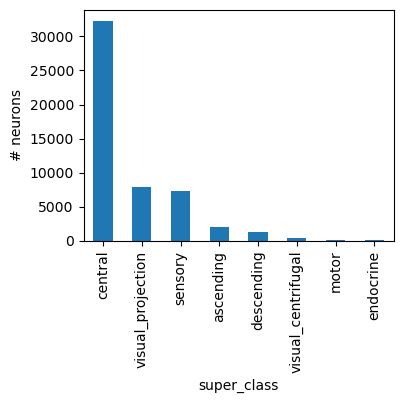

In [21]:
node_info['super_class'].value_counts().plot.bar(figsize=(4, 3))
plt.ylabel("# neurons")

Text(0, 0.5, '# neurons')

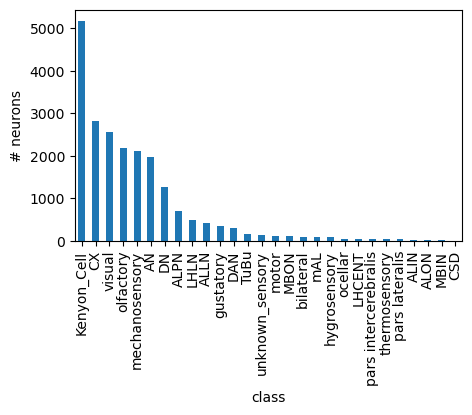

In [22]:
node_info['class'].value_counts().plot.bar(figsize=(5, 3))
plt.ylabel("# neurons")

Text(0, 0.5, '# neurons')

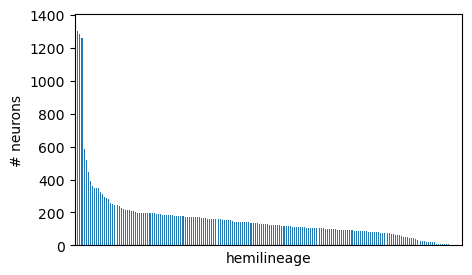

In [23]:
node_info['hemilineage'].value_counts().plot.bar(figsize=(5, 3))
plt.xticks([])
plt.ylabel("# neurons")

Text(0, 0.5, '# connections')

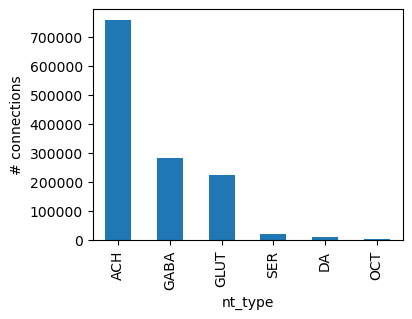

In [24]:
edge_info['nt_type'].value_counts().plot.bar(figsize=(4, 3))
plt.ylabel("# connections")

### B. Degree Distribution

In [5]:
# build the adjacency matrix

# Create a list of unique node IDs
node_ids = np.unique(np.concatenate([edge_info['pre_root_id'], edge_info['post_root_id']]))

# Create an empty adjacency matrix filled with zeros
adjacency_matrix = np.zeros((len(node_ids), len(node_ids)))

# Map node IDs to indices
node_indices = {node_id: index for index, node_id in enumerate(node_ids)}

# Iterate over the rows in the table and update the adjacency matrix
for _, row in edge_info.iterrows():
    pre_root_id = row['pre_root_id']
    post_root_id = row['post_root_id']
    pre_root_index = node_indices[pre_root_id]
    post_root_index = node_indices[post_root_id]
    adjacency_matrix[pre_root_index][post_root_index] = 1

print(adjacency_matrix)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
# construct a graph G from the directed adjacency matrix 
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

# create an undirected version of the graph
G_undirected = nx.to_undirected(G)


# check some properties of the graph
print(f'Is G directed? {nx.is_directed(G)}')
print(f'Is G connected? {nx.is_connected(G_undirected)}')
print('Number of nodes: {}, Number of edges: {}'. format(G.number_of_nodes(), G.number_of_edges()))
print('Number of weakly connected components: {}'. format(nx.number_weakly_connected_components(G)))
print('Number of strongly connected components: {}'. format(nx.number_strongly_connected_components(G)))
print('Density: {}'. format(nx.density(G)))


Is G directed? True
Is G connected? False
Number of nodes: 49339, Number of edges: 1090673
Number of weakly connected components: 72
Number of strongly connected components: 5194
Density: 0.00044804607642286366


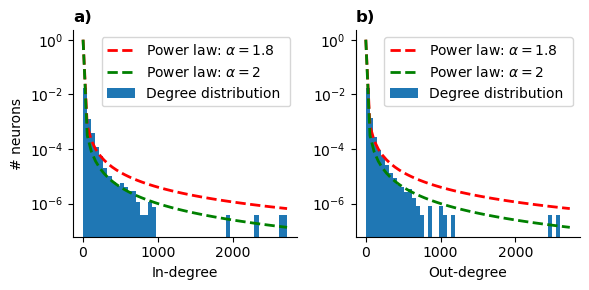

In [12]:
in_degree = [degree for node, degree in G.in_degree()]
out_degree = [degree for node, degree in G.out_degree()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

hist1, bins1, _ = ax1.hist(in_degree, edgecolor='none', bins=50, density=True)
ax1.set_yscale('log')

hist2, bins2, _ = ax2.hist(out_degree, edgecolor='none', bins=50, density=True)
ax2.set_yscale('log')

# Generate power law line data
max_value = max(max(in_degree), max(out_degree))
alpha_1 = 1.8
x = np.linspace(1, max_value, num=50)
y = x ** (-alpha_1)  # Power law distribution with alpha=2

# Generate second power law line data
alpha_2 = 2
x2 = np.linspace(1, max_value, num=50)
y2 = x2 ** (-alpha_2)  # Power law distribution with alpha=3

# Plot power law line with line width 2
ax1.plot(x, y, color='red', linestyle='--', linewidth=2)
ax2.plot(x, y, color='red', linestyle='--', linewidth=2)

# Plot second power law line
ax1.plot(x2, y2, color='green', linestyle='--',linewidth=2)
ax2.plot(x2, y2, color='green', linestyle='--',linewidth=2)


# show legend
# increase the size of the legend
ax1.legend([f'Power law: $\\alpha={alpha_1}$', f'Power law: $\\alpha={alpha_2}$', 'Degree distribution '])
ax2.legend([f'Power law: $\\alpha={alpha_1}$', f'Power law: $\\alpha={alpha_2}$', 'Degree distribution '])


ax1.set_xlabel('In-degree')
ax2.set_xlabel('Out-degree')
ax1.set_ylabel('# neurons')
ax1.set_title("a)", loc="left", fontweight="bold")
ax2.set_title("b)", loc="left", fontweight="bold")

sns.despine(fig=fig)
plt.show()

# save the figure as pdf
fig.savefig('../figs/degree_distribution.pdf', bbox_inches='tight')


In [8]:
# first and second moments of the in-degree distribution
print(f'First moment of the in-degree distribution: {np.mean(in_degree)}')
print(f'Second moment of the in-degree distribution: {np.mean(np.array(in_degree)**2)}')

# first and second moments of the out-degree distribution
print(f'First moment of the out-degree distribution: {np.mean(out_degree)}')
print(f'Second moment of the out-degree distribution: {np.mean(np.array(out_degree)**2)}')




First moment of the in-degree distribution: 22.105697318551247
Second moment of the in-degree distribution: 2636.909118547194
First moment of the out-degree distribution: 22.105697318551247
Second moment of the out-degree distribution: 2082.0338677314094


Recall that a network whose degree distribution follows a power law is a scale-fee network. As such, it has many small degree nodes, not so many around the average degree, and a few large degree nodes (hubs). 
Also the divergence of the second moment resambles exactly the behavior of the pwer law distribution, which is indeed said to be scale-free. 

Our distrbution seems to be at the boundary between anomalous and scale-free regime, but more likely to be scale-free (look at the first moment which is finite and second moment which is large). It's definitely not a random network (alpha >3).

In [9]:
# Step 1: Get the largest connected component
largest_component = max(nx.strongly_connected_components(G), key=len)
subgraph = G.subgraph(largest_component)

# Step 2: Select a subset of landmark nodes
num_landmarks = 100  # Adjust the number of landmarks as needed
landmarks = random.sample(largest_component, num_landmarks)

# Step 3: Compute shortest paths from landmarks to all other nodes
shortest_paths = {}
for landmark in landmarks:
    shortest_paths[landmark] = nx.shortest_path_length(subgraph, source=landmark)

# Step 4: Estimate average shortest path length for each node
avg_shortest_path_lengths = {}
for node in subgraph.nodes:
    total_path_length = sum(shortest_paths[landmark].get(node, 0) for landmark in landmarks)
    avg_shortest_path_lengths[node] = total_path_length / num_landmarks

# Calculate the overall average shortest path length
approx_avg_shortest_path = sum(avg_shortest_path_lengths.values()) / len(avg_shortest_path_lengths)

print("Approximate average shortest path length in the largest connected component:", approx_avg_shortest_path)


/var/folders/qx/mbfp35d17jz5g1qfw4xsv3yc0000gn/T/ipykernel_4744/2962878223.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  landmarks = random.sample(largest_component, num_landmarks)


Approximate average shortest path length in the largest connected component: 4.105620492584042


In [10]:
avg_deg = np.mean(in_degree)
# check the small world property    
np.log(51405)/np.log(avg_deg)

3.5038977909699716

The Barabasi-Albert model

This model generates scale-free graphs with a power-law degree distribution.

For the BA model, we have seen that $\langle k \rangle = 2m$ .

However the BA model creates undirected graphs and will not be meaningful for the proceeding of this analysis.

### C. Other Properties of the Graph

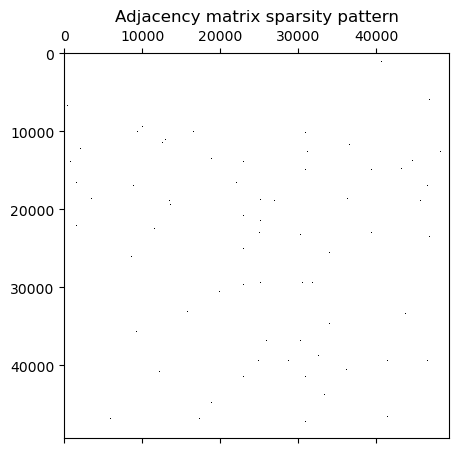

In [11]:
# sparsity of the graph
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('Adjacency matrix sparsity pattern')
# use spy to visualize the sparsity pattern of the adjacency
ax.spy(adjacency_matrix);

In [13]:
# overall centrality measures

# clustering coefficient
clustering_coefficient = nx.clustering(G)

# eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# compute the average clustering coefficient
avg_clustering_coefficient = np.mean(list(clustering_coefficient.values()))

# compute the average eigenvector centrality
avg_eigenvector_centrality = np.mean(list(eigenvector_centrality.values()))

print(f'Average clustering coefficient: {avg_clustering_coefficient}')
print(f'Average eigenvector centrality: {avg_eigenvector_centrality}')

Average clustering coefficient: 0.14409839447853173
Average eigenvector centrality: 0.0010894835768673536


In [14]:
# now compute the global clustering coefficient
global_clustering_coefficient = nx.transitivity(G)
print(f'Global clustering coefficient: {global_clustering_coefficient}')

Global clustering coefficient: 0.055393233632308365


### D. Node Clustering

##### Spectral Analysis

A useful mathematical framework that reveals properties of the graph or network. We will use spectral embeddings to perform clustering.


In [15]:
# we already computed the first 8 eigevector embeddings for all the 6 neuro transmitter types (look at the graph_prep notebook)

spectral_embedding = pd.read_pickle('../data/embeddings/spectral_embedding.pkl')

print('Spectral embedding shape:',spectral_embedding.shape)

spectral_embedding.head()

Spectral embedding shape: (51405, 48)


,spectral_ACH_0,spectral_ACH_1,spectral_ACH_2,spectral_ACH_3,spectral_ACH_4,spectral_ACH_5,spectral_ACH_6,spectral_ACH_7,spectral_SER_0,spectral_SER_1,...,spectral_DA_6,spectral_DA_7,spectral_OCT_0,spectral_OCT_1,spectral_OCT_2,spectral_OCT_3,spectral_OCT_4,spectral_OCT_5,spectral_OCT_6,spectral_OCT_7
720575940619238582,0.003841,-0.000205,0.000179,-0.000266,-2.730470e-15,-8.565195e-16,-1.991190e-16,4.646272e-16,-0.004184,-0.000167,...,0.000105,0.000088,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092
720575940634854554,0.011270,-0.000668,0.000612,-0.000809,-9.218381e-15,-2.605646e-15,-7.454237e-16,1.494312e-15,-0.004184,-0.000167,...,0.000113,0.000095,-0.004452,0.000360,-0.000199,-0.000024,-0.000085,0.000113,-0.000060,0.000096
720575940607923465,0.002681,-0.000128,0.000129,-0.000165,-1.789259e-15,-6.003157e-16,-1.130452e-16,3.054305e-16,-0.004184,-0.000167,...,0.000104,0.000087,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092
720575940630125562,0.006082,-0.000304,0.000294,-0.000374,-3.994143e-15,-1.274669e-15,-2.766731e-16,6.797471e-16,-0.004184,-0.000167,...,0.000104,0.000087,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092
720575940627841795,0.009046,-0.000378,0.000456,-0.000600,-6.726305e-15,-2.289124e-15,-4.042979e-16,1.159410e-15,-0.004184,-0.000167,...,0.000163,0.000150,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092


In [16]:
node2vec_embedding = pd.read_pickle('../data/embeddings/node2vec_embedding.pkl')

print('Node2vec embedding shape:',node2vec_embedding.shape)

node2vec_embedding.head()

Node2vec embedding shape: (51405, 48)


,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,node2vec_ACH_4,node2vec_ACH_5,node2vec_ACH_6,node2vec_ACH_7,node2vec_SER_0,node2vec_SER_1,...,node2vec_DA_6,node2vec_DA_7,node2vec_OCT_0,node2vec_OCT_1,node2vec_OCT_2,node2vec_OCT_3,node2vec_OCT_4,node2vec_OCT_5,node2vec_OCT_6,node2vec_OCT_7
720575940621280688,-2.191900,0.049500,-0.072872,2.529746,-0.076199,-0.797629,0.910458,2.138495,0.024376,0.049488,...,2.257592,-1.052635,-0.086376,-0.016342,-0.075253,0.132493,0.043961,-0.032677,0.089628,0.128388
720575940629174889,-1.859022,1.641020,0.985564,2.125586,-0.007060,1.693392,-0.502335,0.876726,0.076958,-1.087816,...,1.963795,-0.368879,0.061196,0.024918,0.113039,0.013703,0.092897,-0.082858,-0.096461,-0.012831
720575940637132389,-1.602327,0.615010,0.530065,1.076127,-0.032424,2.005130,-0.967994,0.755368,0.100470,-0.249987,...,1.295472,-1.272117,0.060951,0.014239,-0.058449,-0.046567,-0.092479,0.090280,0.040239,-0.106398
720575940654777505,-6.589922,-6.693934,2.004244,0.055977,-4.032084,3.622172,8.605543,3.299473,-0.115199,0.002871,...,0.115346,-0.042695,0.112006,0.021041,0.086480,0.051845,-0.034308,-0.000330,-0.061942,0.119736
720575940616159371,-6.747396,-7.012646,2.138878,0.055543,-4.097299,3.801588,8.909692,3.433254,-0.042529,0.076106,...,-0.012369,-0.027677,0.123636,0.086710,0.055061,0.047037,-0.039150,-0.109720,-0.061458,-0.098871


T-SNE map using node spectral and/or node2vec features

In [18]:
# select first 24 columns of spectral embedding
spectral_embedding_24 = spectral_embedding.iloc[:, :24]

# lets now create a T-SNE map using node spectral embeddings
import seaborn as sns
from sklearn.manifold import TSNE

# create a TSNE object
tsne = TSNE(perplexity = 50, n_components=2, random_state=23, learning_rate = 'auto')

tsne_features = tsne.fit_transform(spectral_embedding_24)

tsne_df = pd.DataFrame(np.hstack((tsne_features, node_info[['super_class', 'class', 'hemilineage']])), columns=['x', 'y', 'super_class', 'class', 'hemilineage'])

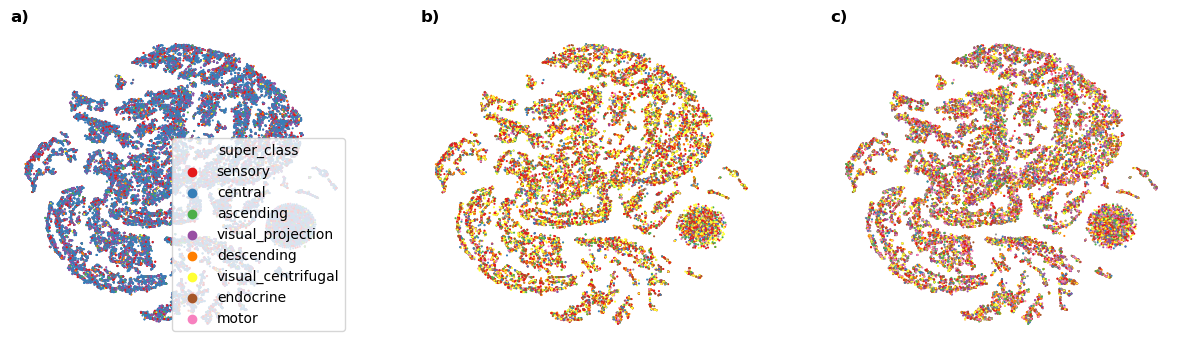

In [19]:
# lets now plot the T-SNE map

# size of the dot smaller

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("a)", loc="left", fontweight="bold")
sns.scatterplot(x='x', y='y', hue='super_class', data=tsne_df, palette='Set1',
                ax=ax1, s=9, marker = '.', legend=True, edgecolor='none')
ax1.axis('off')

ax2.set_title("b)", loc="left", fontweight="bold")
sns.scatterplot(x='x', y='y', hue='class', data=tsne_df, palette='Set1',
                ax=ax2, s=9, marker = '.', legend=False, edgecolor='none')
ax2.axis('off')

# hemilineage without legend 
ax3.set_title("c)", loc="left", fontweight="bold")
sns.scatterplot(x='x', y='y', hue='hemilineage', data=tsne_df, palette='Set1',
                ax=ax3, s=9, legend=False, marker = '.', edgecolor='none')
ax3.axis('off')

#save the figure as pdf
fig.savefig('../figs/tsne_spectral_embedding.pdf', bbox_inches='tight')

##### Node2Vec features:

In [37]:
# select first 24 columns of the node2vec embedding
node2vec_embedding_24 = node2vec_embedding.iloc[:, :24]

In [39]:
# lets now create a T-SNE map using node2vec embeddings
# create a TSNE object

tsne_features2 = tsne.fit_transform(node2vec_embedding_24)

tsne_df2 = pd.DataFrame(np.hstack((tsne_features2, node_info[['super_class', 'class', 'hemilineage']])),
                        columns=['x', 'y', 'super_class', 'class', 'hemilineage'])

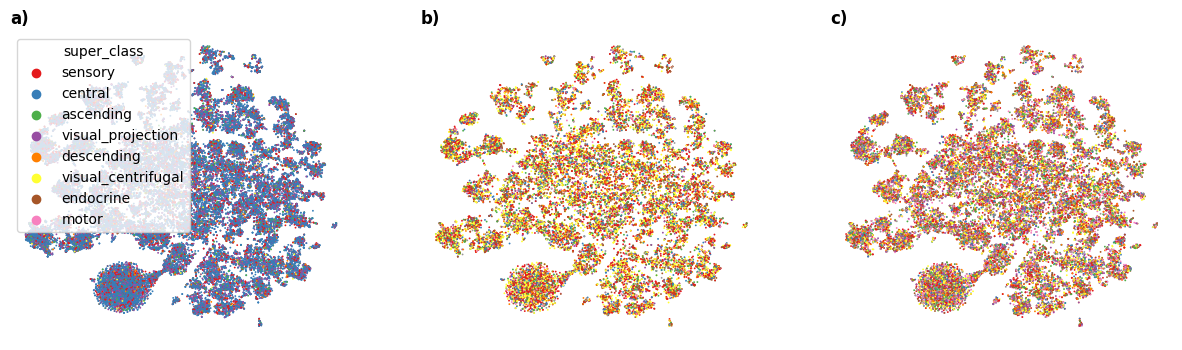

In [42]:
# lets now plot the T-SNE map

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("a)", loc="left", fontweight="bold")
sns.scatterplot(x='x', y='y', hue='super_class', data=tsne_df2, palette='Set1',
                ax=ax1, s=7, marker = '.', legend=True, edgecolor='none')
ax1.axis('off')

ax2.set_title("b)", loc="left", fontweight="bold")
sns.scatterplot(x='x', y='y', hue='class', data=tsne_df2, palette='Set1',
                ax=ax2, legend=False, s=7, marker = '.', edgecolor='none')
ax2.axis('off')

# hemilineage without legend 
ax3.set_title("c)", loc="left", fontweight="bold")
sns.scatterplot(x='x', y='y', hue='hemilineage', data=tsne_df2, palette='Set1',
                ax=ax3, legend=False, s=7, marker = '.', edgecolor='none')
ax3.axis('off')

fig.savefig('../figs/tsne_node2vec_embedding.pdf', bbox_inches='tight')